In [1]:
# Import necessary modules

import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# Set important global options
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.3f}'.format
sns.set_theme(context='talk');

In [2]:
# Homes contains data on home sales, zipcodes is for encoding cities later
homes = pd.read_csv('data/kc_house_data.csv')
zipcodes = pd.read_csv('data/zips.csv')

# Columns suggested to drop by project description
cols_to_drop = (['id','date','sqft_above','sqft_basement',
                'lat','long','sqft_living15','sqft_lot15'])
homes = homes.drop(cols_to_drop,axis=1)

# Exchange the zipcode column for a city column based on zipcode
homes = homes.merge(zipcodes,how='left',on='zipcode').drop('zipcode',axis=1)

# Overview of the data
#homes.info()

In [3]:
#homes[homes.bedrooms > 8]

In [4]:
homes.loc[homes.bedrooms > 20,'bedrooms'] = 3

In [5]:
waterfront_rule = {'NO':0,'YES':1}
waterfronts = homes.waterfront.fillna('NO').map(waterfront_rule)
homes.waterfront = waterfronts

In [6]:
view_rule = {'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}
views = homes.view.fillna('NONE').map(view_rule)
homes.view = views

In [7]:
condition_rule = {'Poor':0,'Fair':1,'Average':2,'Good':3,'Very Good':4}
conditions = homes.condition.map(condition_rule)
homes.condition = conditions

In [8]:
# Numerical rating is the part of grade before the space
grades = homes.grade.apply(lambda x: int(x.split()[0]))
homes.grade = grades

In [9]:
homes.yr_renovated.fillna(0,inplace=True)

def since_reno(home):
    # Use the year built if the house has not been renovated
    if home.yr_renovated < home.yr_built:
        return dt.today().year - home.yr_built
    else:
        return dt.today().year - home.yr_renovated
        
homes['since_reno'] = homes.apply(lambda x:since_reno(x),axis=1)
homes.drop('yr_renovated',inplace=True,axis=1)

In [10]:
homes['age'] = dt.today().year - homes['yr_built']
homes.drop('yr_built',inplace=True,axis=1)

In [11]:
cities = pd.get_dummies(homes.city,prefix='city',sparse=False,drop_first=True)
# Grouped cities is created for plotting purposes later
grouped_cities = homes.copy().groupby('city')
homes.drop('city',inplace=True,axis=1)
#cities.head()

<hr>

Text(0.5, 1.0, 'Price vs. Living Area')

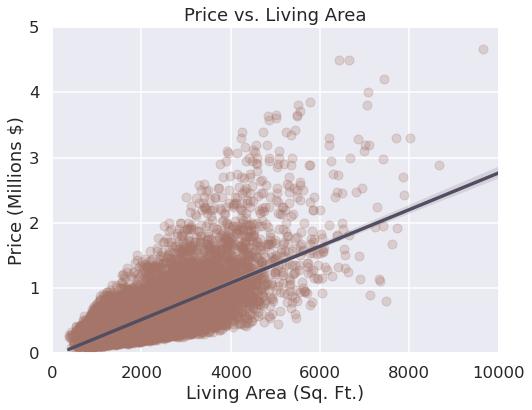

In [12]:
fig,ax = plt.subplots(figsize = (8,6))
sns.regplot(homes.sqft_living,homes.price,scatter_kws={'alpha':0.25,'color':"#a57569"},
                        line_kws={"color":'#524d60'})
ax.set_ylim(0,5e6)
ax.set_xlim(0,1e4)
ax.set_yticklabels(['0','1','2','3','4','5']);
ax.set_ylabel('Price (Millions $)')
ax.set_xlabel('Living Area (Sq. Ft.)')
ax.set_title('Price vs. Living Area')

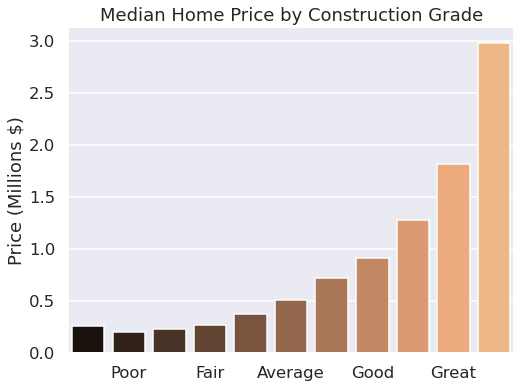

In [13]:
grouped_grades = homes.groupby('grade').price.agg(np.median)
gg = pd.DataFrame(grouped_grades).T
fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(data=gg,palette='copper',ax=ax)
ax.set_yticklabels(ax.get_yticks()/1000000);
ax.set_title('Median Home Price by Construction Grade');
ax.set_ylabel('Price (Millions $)');
ax.set_xlabel('');
ax.set_xticklabels(['','Poor','','Fair','','Average','','Good','','Great','']);

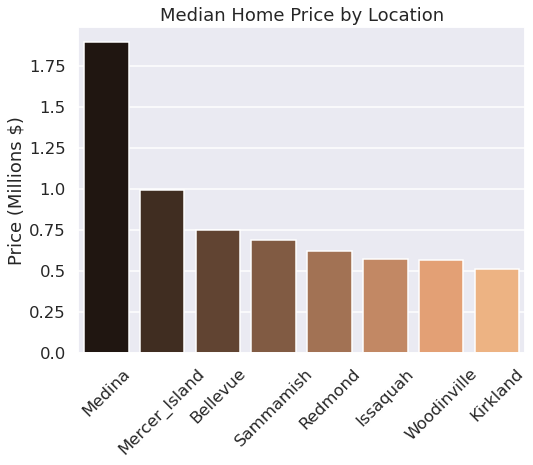

In [14]:
# Reshaping the data and taking only the first 10 cities for visibility
grouped_cities = pd.DataFrame(grouped_cities['price'].agg(np.median).sort_values(ascending=False)[:8]).T
fig,ax = plt.subplots(figsize = (8,6))
sns.barplot(data = grouped_cities,palette='copper')
ax.set_xticklabels(grouped_cities.columns.values[:8], rotation = 45);
ax.set_yticklabels(ax.get_yticks()/1000000);
ax.set_title('Median Home Price by Location');
ax.set_ylabel('Price (Millions $)');
ax.set_xlabel('');

<hr>

<h1>Models</h1>

I start here by adding the encoded location data back to the main dataframe. This was kept separate earlier to keep the plots clean.

In [15]:
# Plotting is done so we can bring the encoded cities data back
homes = pd.concat([homes,cities],axis=1)

In [16]:
# These two features did not provide significant value in the previous model
homes.drop('sqft_lot',inplace=True,axis=1)
homes.drop('since_reno',inplace=True,axis=1)

# These predictors appear to be log normally distributed
homes.price = homes.price.apply(np.log)
homes.sqft_living = homes.sqft_living.apply(np.log)

In [17]:
X_best = homes.drop('price',axis=1)
y_best = homes.price

# Scaling the data this time
scaler_best = StandardScaler()
X_scaled_best = scaler_best.fit_transform(X=X_best,y=y_best)
X_scaled_best = pd.DataFrame(X_scaled_best,columns=X_best.columns)

X_scaled_best = sm.add_constant(X_scaled_best)

# Perform a train test split with the default size
# Random seed e = 2.71828
X_train_best, X_test_best, y_train_best, y_test_best\
     = train_test_split(X_scaled_best,y_best,random_state=271828)

# Create and fit linear regression and get summary
best_regression = LinearRegression().fit(X_train_best,y_train_best)


In [18]:
# Generate the regressions using the same data as from SKLearn
sm_best = sm.OLS(y_train_best,X_train_best).fit()

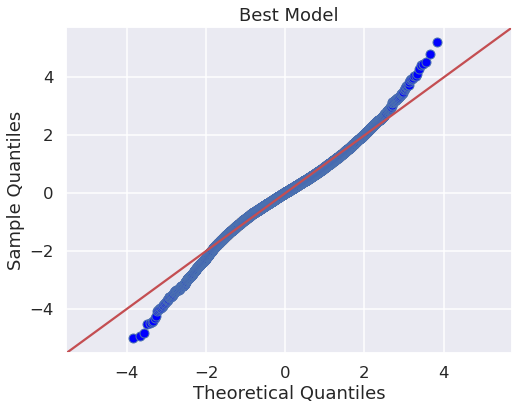

In [89]:
fig,ax3 = plt.subplots(1,figsize = (8,6));

# Generate the three qq-plots
#sm.graphics.qqplot(sm_basic.resid,dist=stats.norm, line='45', fit=True, ax = ax1)
#ax1.set_title('Basic Model');

#sm.graphics.qqplot(sm_mid.resid,dist=stats.norm, line='45', fit=True, ax = ax2)
#ax2.set_title('Mid Model');

sm.graphics.qqplot(sm_best.resid,dist=stats.norm, line='45', fit=True, ax = ax3)
ax3.set_title('Best Model');

Text(0, 0.5, 'Model Predicted Price (Millions $)')

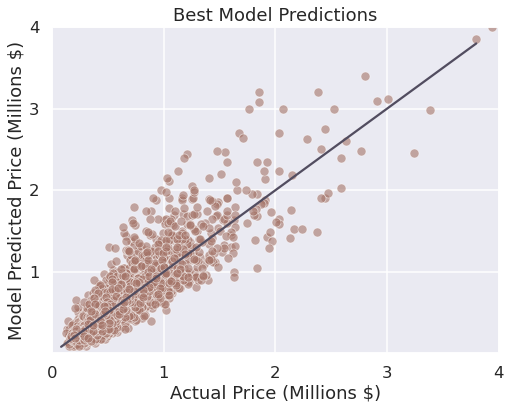

In [74]:
fig,ax1 = plt.subplots(figsize = (8,6))

best_pred = np.exp(best_regression.predict(X_test_best))
y_x = np.linspace(80000,3.8e6,100)


sns.scatterplot(best_pred,np.exp(y_test_best),ax=ax1,alpha=0.6,color="#a57569")
ax1.plot(y_x,y_x,color='#524d60')
ax1.set_title('Best Model Predictions')
ax1.set_xlim(0,4e6)
ax1.set_ylim(0,4e6)
ax1.set_xticks([0,1e6,2e6,3e6,4e6])
ax1.set_yticks([1e6,2e6,3e6,4e6])
ax1.set_xticklabels([0,1,2,3,4])
ax1.set_yticklabels([1,2,3,4])
ax1.set_xlabel('Actual Price (Millions $)')
ax1.set_ylabel('Model Predicted Price (Millions $)')



Text(0.5, 1.0, 'Model Error vs. Price')

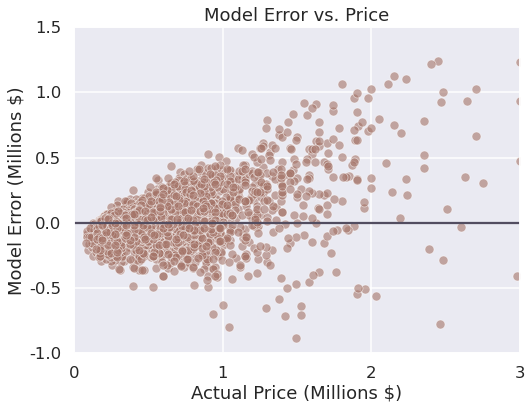

In [79]:
fig,ax2 = plt.subplots(figsize = (8,6))

x = np.linspace(0,1,len(best_pred))
sns.scatterplot(np.exp(y_test_best),-best_pred + np.exp(y_test_best),ax=ax2,alpha=0.6,color="#a57569")
ax2.set_xlim(0,3e6)
ax2.set_ylim(-1e6,1.5e6)
ax2.axhline(0,color='#524d60')
ax2.set_xticks([0,1e6,2e6,3e6])
ax2.set_xticklabels([0,1,2,3])
ax2.set_yticklabels(ax2.get_yticks()/1000000);
ax2.set_xlabel('Actual Price (Millions $)')
ax2.set_ylabel('Model Error (Millions $)')
ax2.set_title('Model Error vs. Price')